# Модель VGG 16 с датасетом EMNIST

In [1]:
! pip install torch-summary -q

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torchvision as tv
from torchsummary import summary
from tqdm import tqdm

In [3]:
def evaluate_accuracy(data_iter, net):
    '''
    Функция подсчета метрики accuracy,
    '''
    acc_sum, n = 0, 0
    net.eval()
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [4]:
def train(net, train_iter, test_iter, trainer, num_epochs):
    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()

        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 50 == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. "
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")
        test_acc = evaluate_accuracy(test_iter, net.to(device))
        print('-' * 20)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Загрузка данных

In [6]:
BATCH_SIZE = 256
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor()
])
train_dataset = tv.datasets.EMNIST('.', split='balanced', train=True, transform=transoforms, download=True)
test_dataset = tv.datasets.EMNIST('.', split='balanced', train=False, transform=transoforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

100%|██████████| 562M/562M [00:16<00:00, 33.3MB/s]


Extracting ./EMNIST/raw/gzip.zip to ./EMNIST/raw


In [7]:
test_dataset[0][0].shape

torch.Size([3, 224, 224])

In [8]:
# dataiter = iter(train_iter)

In [9]:
dataiter = iter(train_dataset)

In [10]:
classes = train_dataset.classes

Размер изображения torch.Size([224, 224])
r


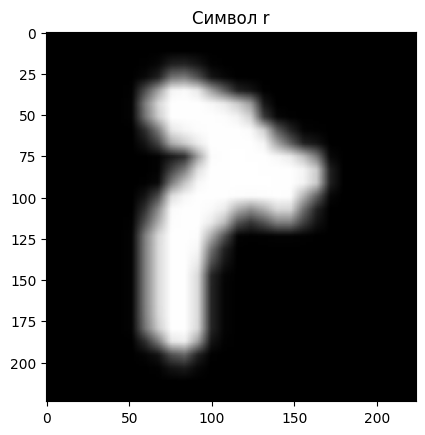

In [11]:
data = next(dataiter)
features, labels = data
print('Размер изображения', features[0].shape)
label = classes[labels]
print(label)
plt.imshow(torch.squeeze(features[0]), cmap = 'gray')
# plt.title('Класс '+ str(labels[0].item()))
plt.title('Символ ' + str(label))
plt.show()

In [12]:
dataiter = iter(train_iter)
data = next(dataiter)
features, labels = data
print('Количество классов:', len(torch.unique(labels)))
print('Классы:', torch.unique(labels))
print('Индексы и классы:', train_dataset.class_to_idx)
print('Классы', train_dataset.classes)

Количество классов: 47
Классы: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46])
Индексы и классы: {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15, 'G': 16, 'H': 17, 'I': 18, 'J': 19, 'K': 20, 'L': 21, 'M': 22, 'N': 23, 'O': 24, 'P': 25, 'Q': 26, 'R': 27, 'S': 28, 'T': 29, 'U': 30, 'V': 31, 'W': 32, 'X': 33, 'Y': 34, 'Z': 35, 'a': 36, 'b': 37, 'd': 38, 'e': 39, 'f': 40, 'g': 41, 'h': 42, 'n': 43, 'q': 44, 'r': 45, 't': 46}
Классы ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']


## Инициализация модели

In [14]:
# model = tv.models.vgg16(pretrained=True)
# model = tv.models.vgg16(weights='VGG16_Weights', progress=True)
model = tv.models.vgg16(progress=True)

In [15]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
# Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False

In [23]:
model.classifier[6]
# model.classifier[6] = torch.nn.Linear(4096, 3).to(device)

Linear(in_features=4096, out_features=1000, bias=True)

In [24]:
# меняем последний слой
model.classifier[6] = nn.Linear(in_features=4096, out_features=47)

In [25]:
# Собираем параметры для обучения
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [26]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [27]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

## Обучение модели

In [28]:
train(model, train_iter, test_iter, trainer, 3)

Step 0. time since epoch: 2.869. Train acc: 0.035. Train Loss: 3.847
Step 50. time since epoch: 82.953. Train acc: 0.089. Train Loss: 3.759
Step 100. time since epoch: 164.249. Train acc: 0.152. Train Loss: 3.667
Step 150. time since epoch: 244.634. Train acc: 0.196. Train Loss: 3.583
Step 200. time since epoch: 325.298. Train acc: 0.236. Train Loss: 3.505
Step 250. time since epoch: 406.086. Train acc: 0.263. Train Loss: 3.432
Step 300. time since epoch: 486.613. Train acc: 0.284. Train Loss: 3.365
Step 350. time since epoch: 567.599. Train acc: 0.303. Train Loss: 3.303
Step 400. time since epoch: 648.006. Train acc: 0.316. Train Loss: 3.244
--------------------
epoch 1, loss 3.2006, train acc 0.327, test acc 0.499, time 800.5 sec
Step 0. time since epoch: 1.574. Train acc: 0.500. Train Loss: 2.739
Step 50. time since epoch: 82.091. Train acc: 0.509. Train Loss: 2.658
Step 100. time since epoch: 162.555. Train acc: 0.517. Train Loss: 2.611
Step 150. time since epoch: 243.286. Train ac

In [30]:
data = {
    'Модель': ['VGG16', 'VGG16', 'VGG16'],
    'Номер эпохи': [1, 2, 3],
    'Test_acc': [0.499, 0.579, 0.622],
    'Test_loss': [3.2006, 2.3234, 1.8065]
}
res_vgg_16 = pd.DataFrame(data)
print(res_vgg_16)

  Модель  Номер эпохи  Test_acc  Test_loss
0  VGG16            1     0.499     3.2006
1  VGG16            2     0.579     2.3234
2  VGG16            3     0.622     1.8065


In [81]:
model = tv.models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [82]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [83]:
# Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False

In [84]:
model.classifier[6].out_features = 47


model.classifier[6] = nn.Linear(in_features=4096, out_features=47)

# заморозка весов предобученной модели в части features
# for param in model.features.parameters():
#     param.requires_grad = False

# Вопрос - а надо веса завомрживать в части classifier???

# Убираем требование градиента:
# for param in model.parameters():
#     param.requires_grad = False

In [85]:
# проверяем какие веса будем учить:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [86]:
# optimizer
# optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(params_to_update, lr=0.001)
# loss function
# loss function
# criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss(reduction='sum')

In [87]:
# validation function
def validate(model, test_dataloader):
    model.to(device) ###
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    # for int, data in enumerate(test_dataloader):
    for i, data in tqdm(enumerate(test_dataloader),total=len(test_dataloader),leave = True):
        data, target = data[0].to(device), data[1].to(device)
        output = model(data)
        loss = criterion(output, target)

        val_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        val_running_correct += (preds == target).sum().item()

    val_loss = val_running_loss/len(test_dataloader.dataset)
    # val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
    val_accuracy = val_running_correct/len(test_dataloader.dataset)
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
    return val_loss, val_accuracy

In [88]:
# training function
def fit(model, train_dataloader):
    model.to(device) ##
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    train_loss_sum, n, start = 0, 0, time.time()
    # for i, data in enumerate(train_dataloader):
    for i, data in tqdm(enumerate(train_dataloader),total=len(train_dataloader),leave = True):
        # train_loss_sum, n, start = 0, 0, time.time()
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_loss_sum += loss.item() ##
        train_running_correct += (preds == target).sum().item()
        n += target.shape[0] ##
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. "
                    f"Train acc: {train_running_correct / n:.4f}. Train Loss: {train_loss_sum / n:.4f}")
        # test_acc = evaluate_accuracy(test_iter, net.to(device)) ##
    train_loss = train_running_loss/len(train_dataloader.dataset)
    # train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    train_accuracy = train_running_correct/len(train_dataloader.dataset)
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}')

    return train_loss, train_accuracy

In [89]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
for epoch in range(1):
    # train_epoch_loss, train_epoch_accuracy = fit(vgg16, trainloader)
    # val_epoch_loss, val_epoch_accuracy = validate(vgg16, testloader)
    train_epoch_loss, train_epoch_accuracy = fit(model, train_iter)
    val_epoch_loss, val_epoch_accuracy = validate(model, test_iter)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()
print((end-start)/60, 'minutes')


  0%|          | 1/441 [00:01<13:00,  1.77s/it]

Step 0. time since epoch: 1.777. Train acc: 0.0430. Train Loss: 3.9311


 12%|█▏        | 51/441 [01:31<11:28,  1.77s/it]

Step 50. time since epoch: 91.515. Train acc: 0.3199. Train Loss: 2.7053


 23%|██▎       | 101/441 [03:00<09:54,  1.75s/it]

Step 100. time since epoch: 180.767. Train acc: 0.4114. Train Loss: 2.2850


 34%|███▍      | 151/441 [04:29<08:18,  1.72s/it]

Step 150. time since epoch: 269.557. Train acc: 0.4572. Train Loss: 2.0648


 46%|████▌     | 201/441 [05:58<07:08,  1.78s/it]

Step 200. time since epoch: 358.805. Train acc: 0.4860. Train Loss: 1.9229


 57%|█████▋    | 251/441 [07:29<06:13,  1.96s/it]

Step 250. time since epoch: 449.809. Train acc: 0.5063. Train Loss: 1.8237


 68%|██████▊   | 301/441 [08:58<04:09,  1.78s/it]

Step 300. time since epoch: 538.331. Train acc: 0.5219. Train Loss: 1.7495


 80%|███████▉  | 351/441 [10:26<02:35,  1.72s/it]

Step 350. time since epoch: 626.641. Train acc: 0.5342. Train Loss: 1.6907


 91%|█████████ | 401/441 [11:55<01:10,  1.75s/it]

Step 400. time since epoch: 715.544. Train acc: 0.5433. Train Loss: 1.6432


100%|██████████| 441/441 [13:05<00:00,  1.78s/it]


Train Loss: 1.6109, Train Acc: 0.5498


100%|██████████| 74/74 [02:08<00:00,  1.73s/it]

Val Loss: 1.0732, Val Acc: 0.7107
15.232842775185903 minutes


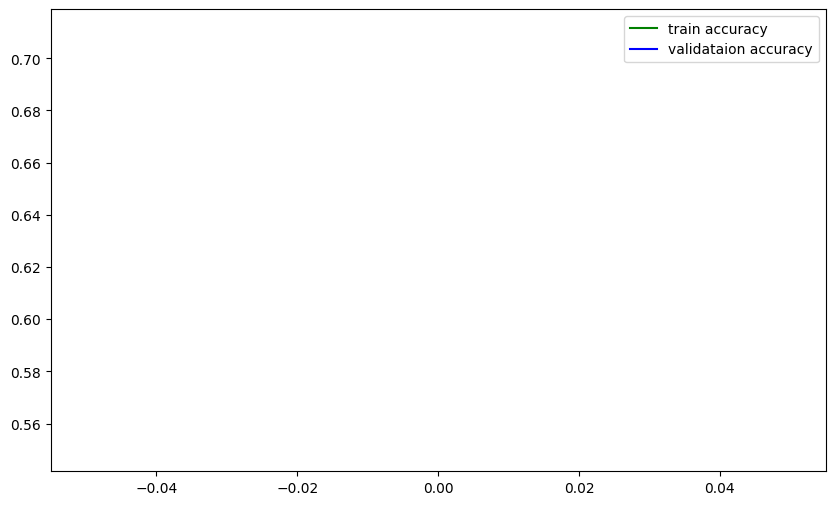

In [90]:
plt.figure(figsize=(10, 6))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.legend()
# plt.savefig('accuracy.png')
plt.show()

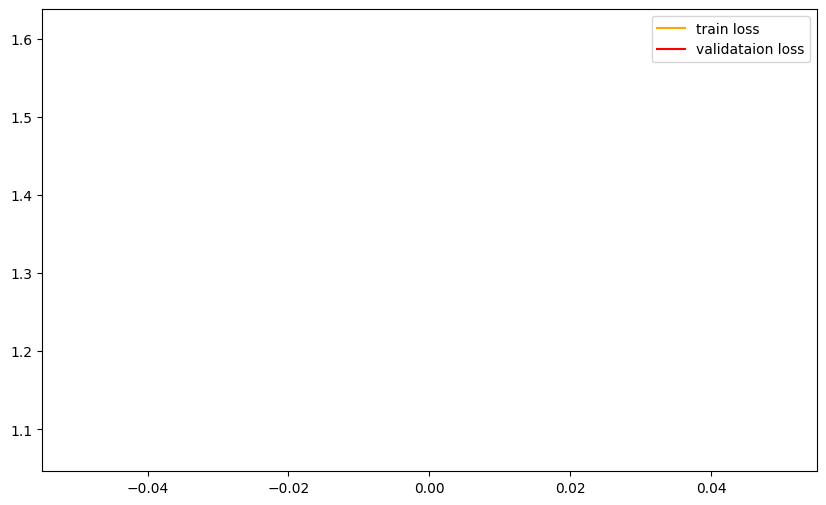

In [91]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.legend()
# plt.savefig('loss.png')
plt.show()

In [2]:
data = {
    'Модель': ['ResNet18', 'ResNet18', 'ResNet18'],
    'Номер эпохи': [1, 2, 3],
    'Test_acc': [0.780, 0.79, 0.798],
    'Test_loss': [0.7891, 0.6813, 0.6304]
}
res = pd.DataFrame(data)
print(res)

     Модель  Номер эпохи  Test_acc  Test_loss
0  ResNet18            1     0.780     0.7891
1  ResNet18            2     0.790     0.6813
2  ResNet18            3     0.798     0.6304


In [3]:
data = {
    'Модель': ['VGG16', 'VGG16', 'VGG16'],
    'Номер эпохи': [1, 2, 3],
    'Test_acc': [0.499, 0.579, 0.622],
    'Test_loss': [3.2006, 2.3234, 1.8065]
}
res_vgg_16 = pd.DataFrame(data)
print(res_vgg_16)

  Модель  Номер эпохи  Test_acc  Test_loss
0  VGG16            1     0.499     3.2006
1  VGG16            2     0.579     2.3234
2  VGG16            3     0.622     1.8065


In [4]:

res = pd.concat([res, res_vgg_16], ignore_index=True)
print(res)

     Модель  Номер эпохи  Test_acc  Test_loss
0  ResNet18            1     0.780     0.7891
1  ResNet18            2     0.790     0.6813
2  ResNet18            3     0.798     0.6304
3     VGG16            1     0.499     3.2006
4     VGG16            2     0.579     2.3234
5     VGG16            3     0.622     1.8065
